# PV module model and system simple evaluation based on real installation data

In [27]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pvlib import pvsystem
import math
import datetime

In [28]:
PVsystem = {
    'n_modules': 24, #Number of modules
    'tilt': 39, #Degrees
    'n_mod_series': 13, #modules in series
    'n_array_parallel': 0.065, #arrays in parallel
    'Pinverter': 1.2, #kW
    'DC_V_datalogger_scale':0.1, #DC datalogger scale: 10 mV in the voltmeter = 1 DC Volt 
    'DC_I_datalogger_scale': 1/5, #DC datalogger scale: 5 mV in the Ammeter = 1 Amp
}

parameters = {
    'Name': 'BP275',
    'BIPV': 'N',
    'Date': '10/5/2009',
    'T_NOCT': 47,
    'A_c': 0.66,
    'N_s': 48,
    'I_sc_ref': 4.48,
    'V_oc_ref': 21.4,
    'I_mp_ref': 4.16,
    'V_mp_ref': 17,
    'alpha_sc': 0.002056,
    'beta_oc': -0.09636,
    'a_ref': 1.05347,
    'I_L_ref': 5.195649,
    'I_o_ref': 4.80738e-09,
    'R_s': 0.278062,
    'R_sh_ref': 339.72,
    'Adjust': 7.075894,
    'gamma_r': -0.6,
    'Version': 'MM106',
    'PTC': 72.5,
    'Technology': 'Mono-c-Si',
    'frame_area': 0.636,
    'T_Isc': 0.065, #%/C
    'T_V': 80, #mV/C
    'T_P': 0.5, #%/C
}


In [29]:
file = 'data/Monitoring PV system.xls'
df = pd.read_excel(file, sheet_name='PV 19-26March 29-4 april', skiprows=[0,1,2,3,4,5,5], skipfooter=2, )
#dfs = dfs.iloc[:, :-1]
df.columns=['date','time','logV', 'logA','logCounts','radiation', 'day_number', 'RH', 'Tamb']
#dfs.dtypes
df['Datetime'] =  df['date'].astype(str) + ' ' + df['time'].astype(str)
df = df.set_index('Datetime')
df = df.drop(['date','time'], axis=1)
df.index = pd.to_datetime(df.index)

df['DC_V'] = df['logV']/10
df['DC_A'] = df['logA']/5
df['DC_W'] = df['DC_V'] * df['DC_A']
df['radiation_norm'] = df['radiation']/ math.cos(math.radians(PVsystem['tilt']))
df['Array_eff'] = df['DC_W'] / (df['radiation_norm'] * PVsystem['n_modules'] * parameters['frame_area'])

# https://pvpmc.sandia.gov/modeling-steps/2-dc-module-iv/cell-temperature/pvsyst-cell-temperature-model/
alpha = 0.9
eta_m = 0.1
U0 = 15
U1 = 6.28
ave_windvel = 5
df['Tc'] = df['Tamb'] + df['radiation_norm'] * (alpha*(1-eta_m)/(U0+U1*ave_windvel))
df

,logV,logA,logCounts,radiation,day_number,RH,Tamb,DC_V,DC_A,DC_W,radiation_norm,Array_eff,Tc
Datetime,,,,,,,,,,,,,
2010-03-19 15:00:00,2106.3,4.3463,0,123.9,78,64.94,12.61,210.63,0.86926,183.092234,159.429510,0.075237,15.393144
2010-03-19 15:01:00,2092.5,4.3684,0,124.7,78,64.67,12.61,209.25,0.87368,182.817540,160.458918,0.074642,15.411115
2010-03-19 15:02:00,2095.9,4.3795,1,125.5,78,65.08,12.56,209.59,0.87590,183.579881,161.488326,0.074476,15.379085
2010-03-19 15:03:00,2111.4,4.3695,0,126.3,78,65.01,12.44,211.14,0.87390,184.515246,162.517733,0.074381,15.277055
2010-03-19 15:04:00,2098.7,4.4144,0,126.7,78,64.81,12.56,209.87,0.88288,185.290026,163.032437,0.074458,15.406040
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-04-04 14:54:00,2477.8,24.6040,2,681.4,94,57.40,9.85,247.78,4.92080,1219.275824,876.797968,0.091103,25.156171
2010-04-04 14:55:00,2467.9,24.7200,2,670.8,94,57.61,10.01,246.79,4.94400,1220.129760,863.158317,0.092608,25.078065
2010-04-04 14:56:00,2465.5,24.7240,2,543.8,94,55.44,10.13,246.55,4.94480,1219.140440,699.739852,0.114143,22.345286


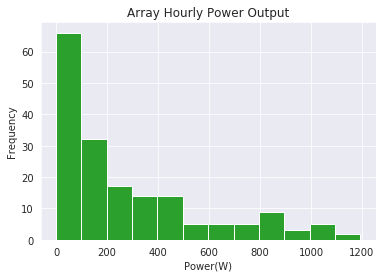

In [30]:
#Array Hourly Power Output
sns.set_style('darkgrid')
ax = df['DC_W'].resample('H').mean().plot.hist(color='C2', bins=12)
ax.set_ylabel('Frequency')
ax.set_xlabel('Power(W)')
ax.set_title('Array Hourly Power Output')
plt.show()

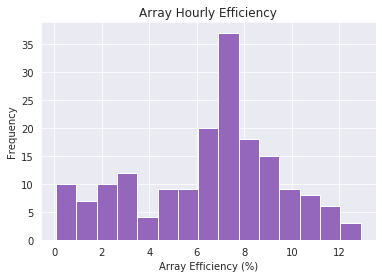

In [31]:
ax = (df['Array_eff']*100).resample('H').mean().plot.hist(color='C4',bins=15)
ax.set_ylabel('Frequency')
ax.set_xlabel('Array Efficiency (%)')
ax.set_title('Array Hourly Efficiency')
plt.show()

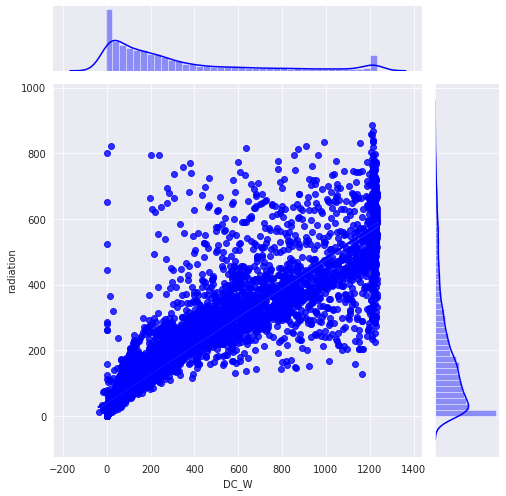

In [32]:
sns.jointplot(x= df['DC_W'],y = df['radiation'],kind = "reg", color="b", height=7)
plt.show()

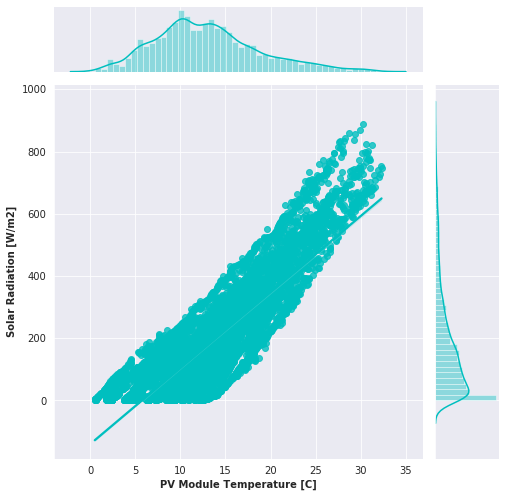

In [33]:
fig = sns.jointplot(x= df['Tc'],y = df['radiation'],kind = "reg", color="c", height=7)
fig.set_axis_labels('PV Module Temperature [C]', 'Solar Radiation [W/m2]', fontsize=10, fontweight='bold')
plt.savefig('Solar Radiation VS Module Temperature.svg')
plt.show()

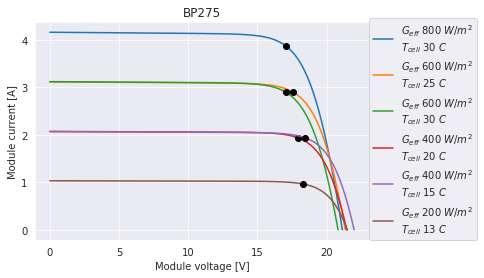

       i_sc       v_oc      i_mp       v_mp       p_mp
0  4.162018  21.145073  3.863332  17.106873  66.089528
1  3.115859  21.362194  2.904249  17.567198  51.019515
2  3.122024  20.837115  2.900855  17.050864  49.462086
3  2.073469  21.466728  1.938446  17.934988  34.766001
4  2.069358  21.997322  1.939297  18.467530  35.814021
5  1.034026  21.508913  0.968852  18.274834  17.705612


In [34]:
# Cases below based on performance of real system as per data above. 

cases = [
    (800, 30),
    (600, 25),
    (600, 30),
    (400, 20),
    (400, 15),
    (200, 13)
]

conditions = pd.DataFrame(cases, columns=['Geff', 'Tcell'])

# adjust the reference parameters according to the operating
# conditions using the De Soto model:
IL, I0, Rs, Rsh, nNsVth = pvsystem.calcparams_desoto(
    conditions['Geff'],
    conditions['Tcell'],
    alpha_sc=parameters['alpha_sc'],
    a_ref=parameters['a_ref'],
    I_L_ref=parameters['I_L_ref'],
    I_o_ref=parameters['I_o_ref'],
    R_sh_ref=parameters['R_sh_ref'],
    R_s=parameters['R_s'],
    EgRef=1.121,
    dEgdT=-0.0002677
)

# plug the parameters into the SDE and solve for IV curves:
curve_info = pvsystem.singlediode(
    photocurrent=IL,
    saturation_current=I0,
    resistance_series=Rs,
    resistance_shunt=Rsh,
    nNsVth=nNsVth,
    ivcurve_pnts=100,
    method='lambertw'
)

# plot the calculated curves:
plt.figure()
for i, case in conditions.iterrows():
    label = (
        "$G_{eff}$ " + f"{case['Geff']} $W/m^2$\n"
        "$T_{cell}$ " + f"{case['Tcell']} $C$"
    )
    plt.plot(curve_info['v'][i], curve_info['i'][i], label=label)
    v_mp = curve_info['v_mp'][i]
    i_mp = curve_info['i_mp'][i]
    # mark the MPP
    plt.plot([v_mp], [i_mp], ls='', marker='o', c='k')

plt.legend(loc=(1.0, 0))
plt.xlabel('Module voltage [V]')
plt.ylabel('Module current [A]')
plt.title(parameters['Name'])
plt.savefig('PV I-V Curve.svg')
plt.show()
#plt.gcf().set_tight_layout(True)


# draw trend arrows
def draw_arrow(ax, label, x0, y0, rotation, size, direction):
    style = direction + 'arrow'
    bbox_props = dict(boxstyle=style, fc=(0.8, 0.9, 0.9), ec="b", lw=1)
    t = ax.text(x0, y0, label, ha="left", va="bottom", rotation=rotation,
                size=size, bbox=bbox_props, zorder=-1)

    bb = t.get_bbox_patch()
    bb.set_boxstyle(style, pad=0.6)


print(pd.DataFrame({
    'i_sc': curve_info['i_sc'],
    'v_oc': curve_info['v_oc'],
    'i_mp': curve_info['i_mp'],
    'v_mp': curve_info['v_mp'],
    'p_mp': curve_info['p_mp'],
}))

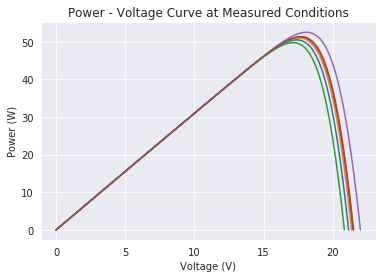

In [35]:
plt.plot(curve_info['v'][0],curve_info['i'][1]*curve_info['v'][0] ,label=label)
plt.plot(curve_info['v'][1],curve_info['i'][1]*curve_info['v'][1] ,label=label)
plt.plot(curve_info['v'][2],curve_info['i'][1]*curve_info['v'][2] ,label=label)
plt.plot(curve_info['v'][3],curve_info['i'][1]*curve_info['v'][3] ,label=label)
plt.plot(curve_info['v'][4],curve_info['i'][1]*curve_info['v'][4] ,label=label)
plt.plot(curve_info['v'][5],curve_info['i'][1]*curve_info['v'][5] ,label=label)
plt.title('Power - Voltage Curve at Measured Conditions')
plt.xlabel('Voltage (V)')
plt.ylabel('Power (W)')
plt.grid(True)
plt.show()

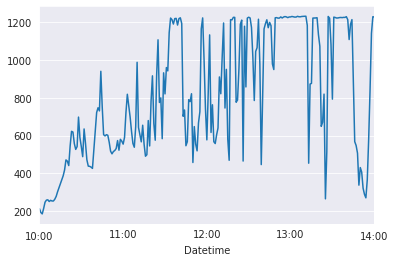

In [36]:
start_date = '2010-03-25 10:00:00'
end_date = '2010-03-25 14:00:00'
period1 = (df.index >= start_date) & (df.index <= end_date)
april = df.loc[period1]
april['DC_W'].plot()
plt.show()